In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the dataset
df = pd.read_csv("/content/BigQuery_IowaLiquorSalesData.csv", parse_dates=['date'], index_col='date')

In [ ]:
# Sort data by date
df = df.sort_index()

In [ ]:
# Ensure 'date' column is in datetime format
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)  # 1 if weekend, 0 otherwise
df['quarter'] = df.index.quarter
df['dayofyear'] = df.index.dayofyear

In [ ]:
print(df.columns)

Index(['invoice_and_item_number', 'store_number', 'store_name', 'address',
       'city', 'zip_code', 'store_location', 'county_number', 'county',
       'category', 'category_name', 'vendor_number', 'vendor_name',
       'item_number', 'item_description', 'pack', 'bottle_volume_ml',
       'state_bottle_cost', 'state_bottle_retail', 'bottles_sold',
       'sale_dollars', 'volume_sold_liters', 'volume_sold_gallons', 'year',
       'month', 'day', 'dayofweek', 'is_weekend', 'quarter', 'dayofyear'],
      dtype='object')


In [ ]:
# Select multiple relevant features
features = ['sale_dollars', 'bottles_sold', 'volume_sold_liters',
            'dayofweek', 'month', 'year', 'day',
            'is_weekend', 'quarter']
data = df[features].values

In [ ]:
# Normalize data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [ ]:
# Function to create sequences
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, 0])  # Predicting 'sale_dollars'
    return np.array(X), np.array(y)

In [ ]:
# Define time steps
TIME_STEPS = 10
X, y = create_sequences(data_scaled, TIME_STEPS)

In [ ]:
# Split data into training, validation, and testing
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.2)
test_size = len(X) - train_size - val_size

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [ ]:
# Build LSTM Model
model = Sequential([
    Input(shape=(TIME_STEPS, len(features))),  # Explicit input layer
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

In [ ]:
# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
    loss='mean_squared_error',
    metrics=['mae', 'mape', 'mse']  # Mean Absolute Error, Mean Absolute Percentage Error, MSE
)

In [ ]:
df['sale_dollars'] = df['sale_dollars'].fillna(df['sale_dollars'].median())

In [ ]:
# Train Model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

Epoch 1/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.0045 - mae: 0.0379 - mape: 8.1982 - mse: 0.0045 - val_loss: 2.1074e-04 - val_mae: 0.0067 - val_mape: 77074.5859 - val_mse: 2.1074e-04
Epoch 2/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - loss: 7.8846e-05 - mae: 0.0061 - mape: 1.3093 - mse: 7.8846e-05 - val_loss: 2.0125e-04 - val_mae: 0.0071 - val_mape: 77650.6016 - val_mse: 2.0125e-04
Epoch 3/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 4.9121e-05 - mae: 0.0042 - mape: 0.8977 - mse: 4.9121e-05 - val_loss: 2.0124e-04 - val_mae: 0.0072 - val_mape: 77477.8438 - val_mse: 2.0124e-04
Epoch 4/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 4.4016e-05 - mae: 0.0039 - mape: 0.8372 - mse: 4.4016e-05 - val_loss: 2.0574e-04 - val_mae: 0.0066 - val_mape: 77180.2422 - val_mse: 2.0574e-04
Epoch 5/50
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 5.2839e-05 - mae: 0.0039 - mape: 0.8274 - mse: 5.2839e-05 - val_loss: 2.0973e-04 - val_mae: 0.0065 - val_mape: 7

In [ ]:
# Predict on train, validation, and test sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
# Inverse transform predictions
y_train_inv = scaler.inverse_transform(np.concatenate((y_train_pred, np.zeros((y_train_pred.shape[0], len(features)-1))), axis=1))[:, 0]
y_val_inv = scaler.inverse_transform(np.concatenate((y_val_pred, np.zeros((y_val_pred.shape[0], len(features)-1))), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test_pred, np.zeros((y_test_pred.shape[0], len(features)-1))), axis=1))[:, 0]

y_train_actual = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], len(features)-1))), axis=1))[:, 0]
y_val_actual = scaler.inverse_transform(np.concatenate((y_val.reshape(-1, 1), np.zeros((y_val.shape[0], len(features)-1))), axis=1))[:, 0]
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features)-1))), axis=1))[:, 0]

In [ ]:
# Performance Metrics
mae = mean_absolute_error(y_test_actual, y_test_inv)
print(f"MAE: {mae}")

MAE: 65.49280650645


In [ ]:
# Performance Metrics
mse = mean_squared_error(y_test_actual, y_test_inv)
print(f"MSE: {mse}")

MSE: 6170.210376698664


In [ ]:
# Performance Metrics
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

RMSE: 78.55068667235611


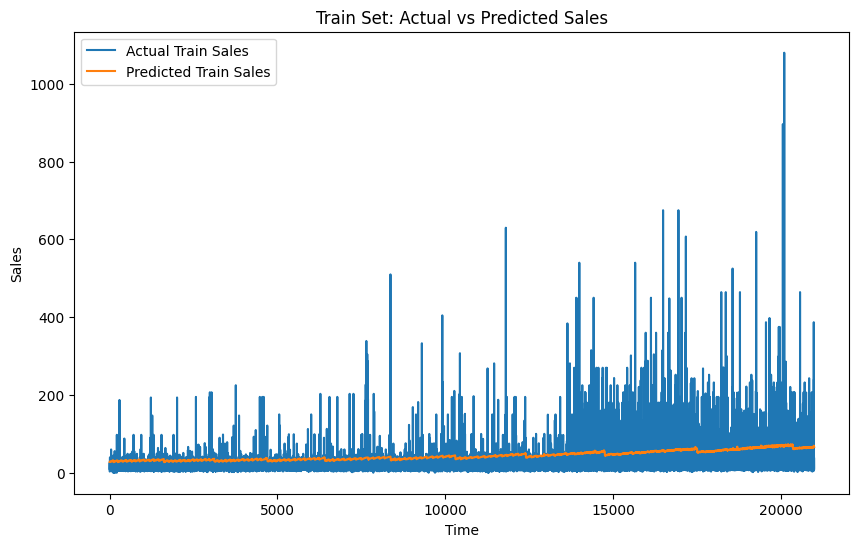

In [ ]:
# Visualization on Training Set
plt.figure(figsize=(10,6))
plt.plot(y_train_actual, label='Actual Train Sales')
plt.plot(y_train_inv, label='Predicted Train Sales')
plt.legend()
plt.title("Train Set: Actual vs Predicted Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()

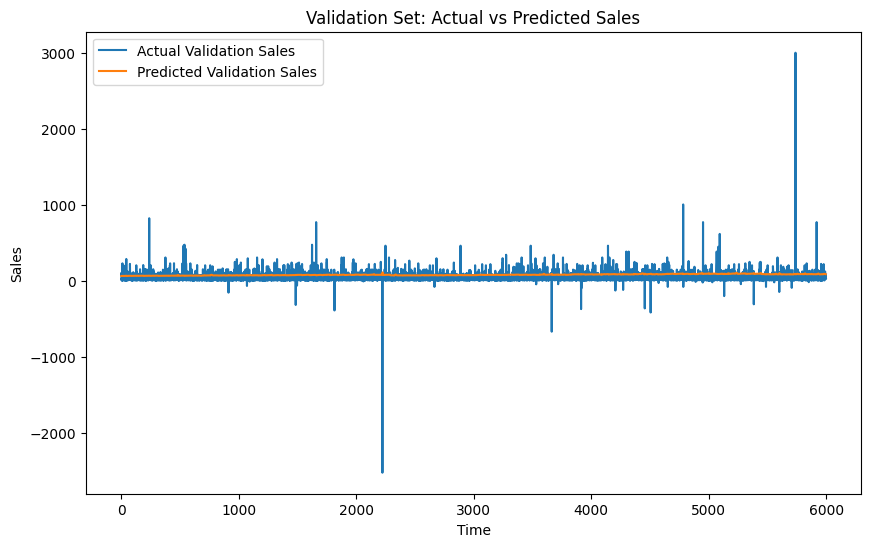

In [ ]:
# Visualization on Validation Set
plt.figure(figsize=(10,6))
plt.plot(y_val_actual, label='Actual Validation Sales')
plt.plot(y_val_inv, label='Predicted Validation Sales')
plt.legend()
plt.title("Validation Set: Actual vs Predicted Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()

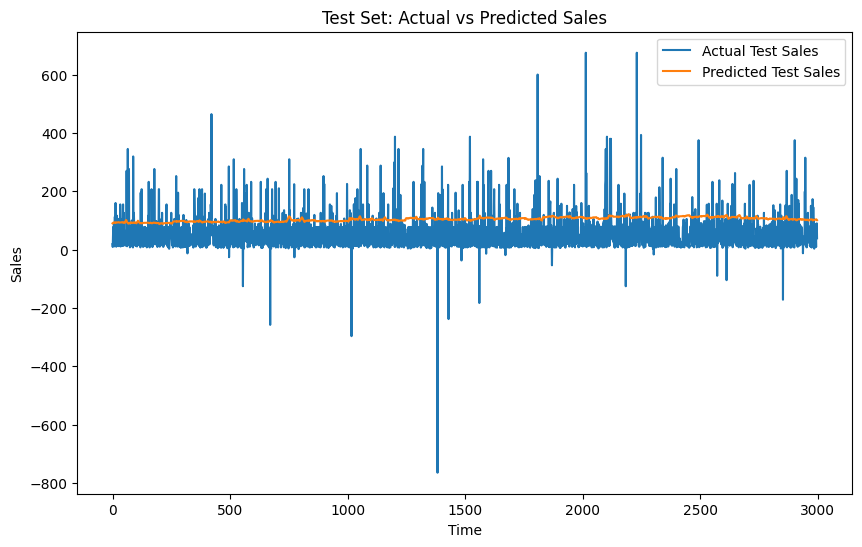

In [ ]:
# Visualization on Test Set
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual Test Sales')
plt.plot(y_test_inv, label='Predicted Test Sales')
plt.legend()
plt.title("Test Set: Actual vs Predicted Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()

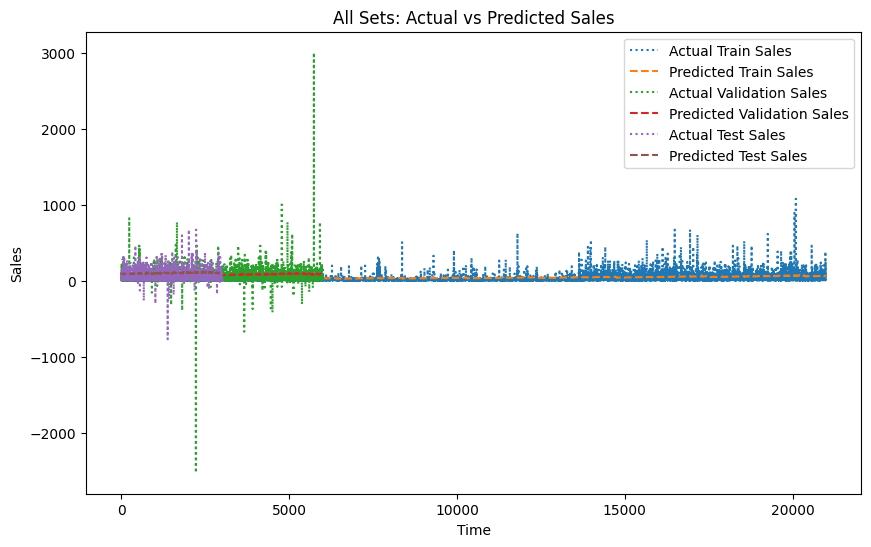

In [ ]:
# Combined Visualization
plt.figure(figsize=(10,6))
plt.plot(y_train_actual, label='Actual Train Sales', linestyle='dotted')
plt.plot(y_train_inv, label='Predicted Train Sales', linestyle='dashed')
plt.plot(y_val_actual, label='Actual Validation Sales', linestyle='dotted')
plt.plot(y_val_inv, label='Predicted Validation Sales', linestyle='dashed')
plt.plot(y_test_actual, label='Actual Test Sales', linestyle='dotted')
plt.plot(y_test_inv, label='Predicted Test Sales', linestyle='dashed')
plt.legend()
plt.title("All Sets: Actual vs Predicted Sales")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Load dataset
df = pd.read_csv("/content/BigQuery_IowaLiquorSalesData.csv", parse_dates=['date'])

In [ ]:
# Sort data by date
df = df.sort_values(by='date')

In [ ]:
# Feature Engineering
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)  # 1 if weekend, 0 otherwise
df['quarter'] = df['date'].dt.quarter
df['dayofyear'] = df['date'].dt.dayofyear

In [ ]:
# Select relevant features
features = ['bottles_sold', 'volume_sold_liters', 'dayofweek', 'month', 'year', 'day', 'is_weekend']
target = 'bottles_sold'  # Predicting demand (bottles sold)

In [ ]:
# Encode liquor names as categorical features
encoder = LabelEncoder()
df['liquor_name_encoded'] = encoder.fit_transform(df['item_description'])

In [ ]:
# Add liquor name to features
features.append('liquor_name_encoded')

In [ ]:
# Initialize scalers
'''scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale input features
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

# Scale target variable
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))  # ✅ Define y_test_scaled properly'''

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))  # Scale target properly
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


In [ ]:
# Scale numeric features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [ ]:
# Prepare sequences for LSTM
sequence_length = 14  # Use past 14 days for prediction
X, y = [], []

for i in range(len(df) - sequence_length):
    X.append(df[features].iloc[i:i+sequence_length].values)
    y.append(df[target].iloc[i+sequence_length])

X, y = np.array(X), np.array(y)

In [ ]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Build LSTM model
model = tf.keras.Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),  # Dropout to reduce overfitting
    LSTM(32, return_sequences=False),
    Dropout(0.2),  # Dropout
    Dense(16, activation="relu"),
    Dense(1)  # Single output neuron
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile model with learning rate and metrics
# model.compile(optimizer=Adam(learning_rate=0.0005), loss="huber", metrics=["mae"])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [ ]:
# Train model
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

model.fit(X_train_scaled, y_train_scaled,
          epochs=200, batch_size=32,
          validation_data=(X_test_scaled, y_test_scaled),
          callbacks=[early_stop])

Epoch 1/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - loss: 0.0352 - mae: 0.1097 - val_loss: 0.0062 - val_mae: 0.0707
Epoch 2/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0025 - mae: 0.0381 - val_loss: 0.0029 - val_mae: 0.0402
Epoch 3/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.0011 - mae: 0.0229 - val_loss: 0.0032 - val_mae: 0.0434
Epoch 4/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 6.6230e-04 - mae: 0.0158 - val_loss: 0.0036 - val_mae: 0.0482
Epoch 5/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 6.0790e-04 - mae: 0.0150 - val_loss: 0.0030 - val_mae: 0.0415
Epoch 6/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 5.6297e-04 - mae: 0.0144 - val_loss: 0.0024 - val_mae: 0.0323
Epoch 7/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 5.6713e-04 - mae: 0.0141 - val_loss: 0.0028 - val_mae: 0.0390
Epoch 8/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 6.5042e-04 - mae: 0.0141 - val_loss: 0.0024 - val_mae: 0.0331
Epoch 9/200


In [ ]:
# Predict future demand
predictions = model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Get shapes
n_samples, timesteps, n_features = X_train.shape

# Reshape X_train
X_train_reshaped = X_train.reshape(-1, n_features)
X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(n_samples, timesteps, n_features)

# Reshape X_test
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])
X_test_scaled = scaler_X.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# Scale target variable y
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))


In [ ]:
# Print sample predictions
print("Sample Predictions:")
print(predictions[:10])

Sample Predictions:
[[0.82590663]
 [0.8259819 ]
 [0.8260137 ]
 [0.82590806]
 [0.826118  ]
 [0.82604903]
 [0.82590586]
 [0.8260139 ]
 [0.82604206]
 [0.82592   ]]


In [ ]:
# Convert predictions back to the original scale
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual values
y_pred_actual = scaler_y.inverse_transform(predictions)  # Inverse transform predicted values

# Print Actual vs Predicted
print("Actual vs Predicted Liquor Sales:")
for actual, predicted in zip(y_test_actual[:10], y_pred_actual[:10]):
    print(f"Actual: {actual[0]:.2f}, Predicted: {predicted[0]:.2f}")

Actual vs Predicted Liquor Sales:
Actual: 0.91, Predicted: 0.84
Actual: 0.87, Predicted: 0.84
Actual: 0.94, Predicted: 0.84
Actual: 0.85, Predicted: 0.84
Actual: 0.88, Predicted: 0.84
Actual: 0.85, Predicted: 0.84
Actual: 0.85, Predicted: 0.84
Actual: 0.85, Predicted: 0.84
Actual: 0.92, Predicted: 0.84
Actual: 0.94, Predicted: 0.84


In [ ]:
print("Scaled y_train min:", y_train_scaled.min(), "max:", y_train_scaled.max())

Scaled y_train min: 0.0 max: 1.0


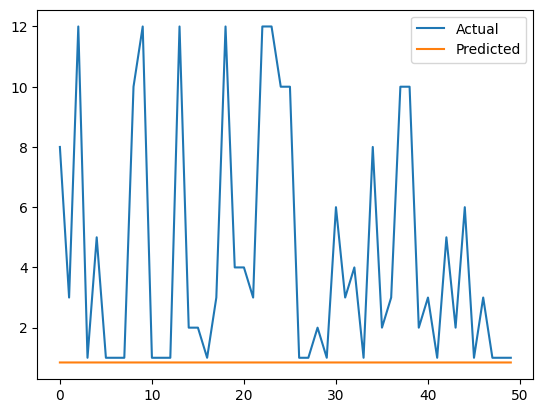

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_actual[:50], label="Actual")
plt.plot(y_pred_actual[:50], label="Predicted")
plt.legend()
plt.show()

In [ ]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred_actual = scaler_y.inverse_transform(y_pred_scaled)

y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Print Actual vs Predicted values
print("Actual vs Predicted Liquor Sales:")
for actual, predicted in zip(y_test_actual[:10], y_pred_actual[:10]):
    print(f"Actual: {actual[0]:.2f}, Predicted: {predicted[0]:.2f}")

In [ ]:
# Make predictions
y_pred_scaled = model.predict(X_test_scaled)

# Ensure inverse transform is done correctly
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))  # Reshape to match expected shape
y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))  # Ensure correct shape

# Print results
print("Actual vs Predicted Liquor Sales:")
for actual, predicted in zip(y_test_actual[:10], y_pred[:10]):
    print(f"Actual: {actual[0]:.2f}, Predicted: {predicted[0]:.2f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Actual vs Predicted Liquor Sales:
Actual: 8.00, Predicted: -0.88
Actual: 3.00, Predicted: -0.84
Actual: 12.00, Predicted: -0.81
Actual: 1.00, Predicted: -0.83
Actual: 5.00, Predicted: -0.82
Actual: 1.00, Predicted: -0.85
Actual: 1.00, Predicted: -0.84
Actual: 1.00, Predicted: -0.80
Actual: 10.00, Predicted: -0.77
Actual: 12.00, Predicted: -0.78
